<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Pr%C3%A9dictions_MoyenneMobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet, nous allons mettre en place trois méthodes de prédictions et comparer les erreurs obtenues :
  - La méthode "naïve"
  - La méthode par moyenne mobile
  - La méthide par moyenne mobile différenciée

# Création de la série temporelle expérimentale

Commençons par créer la série temporelle bruitée avec une tendance et une saisonnalitée :

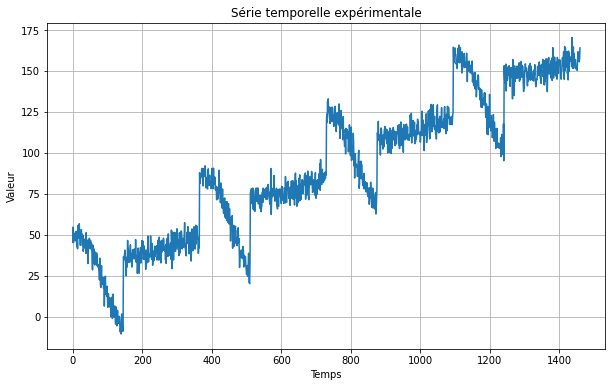

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

# Extraction des données pour l'entrainement et la validation

Maintenant, mettons en place les intervalles de temps pour l'entrainement et la validation. On sépare tout simplement les données entre les intants t=[0:1000[ et t=[1000:1460[ :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration1.png?raw=true" width="600">  

Les données d'entrainement et les instants d'entrainement sont donc au nombre de 1000.  
Les données de validation et les instants de validaton sont donc au nombre de 460.

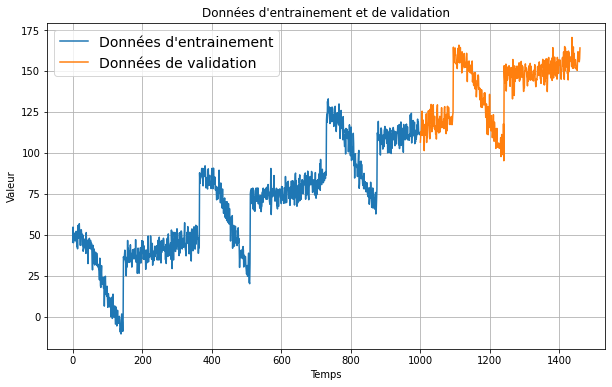

In [3]:
temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

# Affichage des résultats
plt.figure(figsize=(10, 6))
affiche_serie(temps_entrainement, x_entrainement, label="Données d'entrainement")
affiche_serie(temps_validation, x_validation, label="Données de validation")
plt.title("Données d'entrainement et de validation")
plt.show()


In [4]:
print(temps.shape)
print(x_entrainement.shape)
print(x_validation.shape)

(1460,)
(1000,)
(460,)


# Prédiction "naïve"

Il s'agit ici de prédire les valeurs en considérant que les valeurs à $t=t+1$ sont les mêmes qu'à $t$ : $v(t+1) = v(t)$  
On fait cette opération sur les données de validation, donc pour $t\in[1000:1459]$  
Les données prédites sont donc définies sur l'intervalle $t\in[1001:1460]$  

In [5]:
prediciton_naives = serie[temps_separation - 1:]

In [6]:
prediciton_naives.shape

(461,)

Text(0.5, 1.0, "Prédictions naïves (zoom sur l'intervalle de validation)")

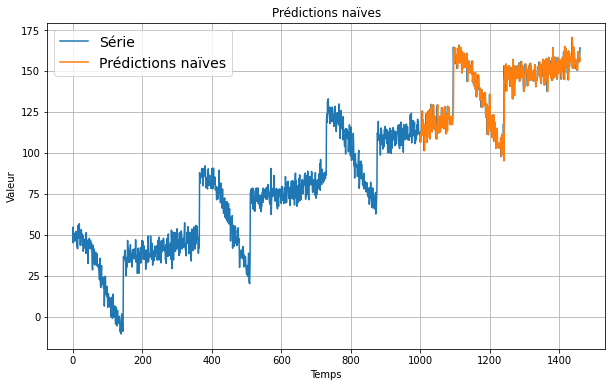

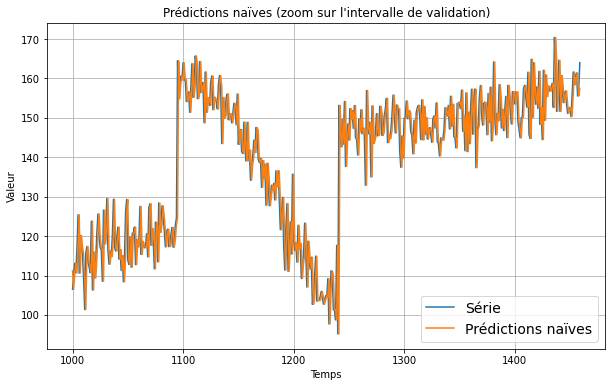

In [10]:
# Affiche les résultats
# Il faut enlever la dernière valeur dans le tableau des données prédites
# car cette dernière valeur correspond à l'instant sur lequel les données
# de validation attendues ne sont pas définies
# Cela est fait avec l'instruction : prediciton_naives[:-1]

plt.figure(figsize=(10, 6))
affiche_serie(temps, serie,label="Série")
affiche_serie(temps_validation, prediciton_naives[:-1],label="Prédictions naïves")
plt.title("Prédictions naïves")

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, x_validation,label="Série")
affiche_serie(temps_validation, prediciton_naives[:-1],label="Prédictions naïves")
plt.title("Prédictions naïves (zoom sur l'intervalle de validation)")

Text(0.5, 1.0, 'Prédictions naïves (zoom sur t=[1000:1010])')

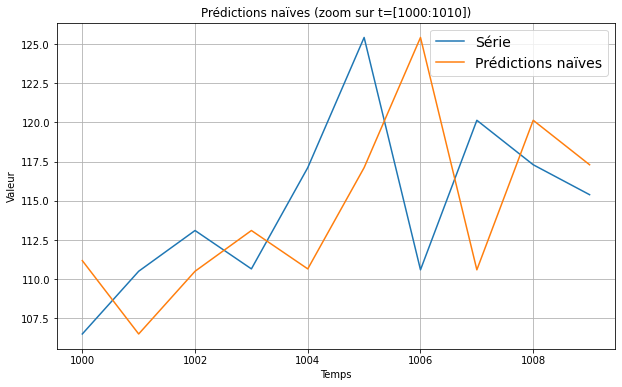

In [11]:
# Zoom des prédictions naïves sur l'intervalle [1000:1010]

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation[:10], x_validation[:10],label="Série")
affiche_serie(temps_validation[:10], prediciton_naives[:10],label="Prédictions naïves")
plt.title("Prédictions naïves (zoom sur t=[1000:1010])")

On observe bien que la série prédite se trouve exactement à un pas de temps de la série d'origine.

# Calcul des erreurs sur la prédiction "naïve"

Calculons l'erreur quadratique moyenne et l'erreur absolue moyenne entre les données attendues et les données prédites sur l'intervalle de validation.  

Erreur quadratique moyenne (mse - mean squared error) : $\frac{1}{N}{\sum\limits_1^N {\left( {y - \hat y} \right)} ^2}$  
  
  
Erreur moyenne absolue (mae - mean absolute value) : $\frac{1}{N}\sum\limits_1^N {\left| {y - \hat y} \right|}$  
  
  
Les prédictions étant réalisées sur l'intervalle $t\in[1001;1460]$ et les données de la séries étant sur l'intervalle $t\in[1000;1459]$ on réalise le calcul de l'erreur sur l'intervalle $t\in[1000;1459]$.  

In [17]:
print(keras.metrics.mean_squared_error(x_validation, prediciton_naives[:-1]).numpy())
print(keras.metrics.mean_absolute_error(x_validation, prediciton_naives[:-1]).numpy())

60.88662860862498
5.74107573731582


Ces résultats vont nous servir de base pour comparer les autres méthodes.

# Prédictions par moyenne mobile

Nous allons maintenant faire des prédictions avec la méthode de la moyenne mobile afin de regarder si on obtient des meilleurs résultats qu'avec la méthode précédente.

Commençons par définir la fonction permettant de calculer la moyenne mobile :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration_MoyenneMobile.png?raw=true" width="800">  

In [53]:
# Fonction permettant de réaliser des prédictions par moyenne mobile
# Si taille_fenetre = 1 alors la prédiction est équivalente à la prédiction "naïve"

def prediction_moyenne_mobile(serie, taille_fenetre):
  prediction = []
  for temps in range(0,len(serie)-taille_fenetre):
    moyenne_sur_fenetre = serie[temps:temps + taille_fenetre].mean()
    prediction.append(moyenne_sur_fenetre)
  return np.array(prediction)

In [52]:
# La dimension du tableau retrouné est égale à la dimension de la serie d'origine - la taille de la fenetre
# car le premier résultat de la moyenne mobile n'est disponible qu'après la première fenêtre
essai = prediction_moyenne_mobile(serie,10)
print(serie.shape)
print(essai.shape)

(1460,)
(1450,)


On applique la moyenne mobile avec une fenetre de 30 jours sur l'intervalle de validation. Les valeurs de la série prédite seront donc le résultat de la moyenne des valeurs sur les 30 instants précédent l'instant t :

Text(0.5, 1.0, "Prédicitons par moyenne mobile sur 30 jours (zoom sur l'intervalle de validation)")

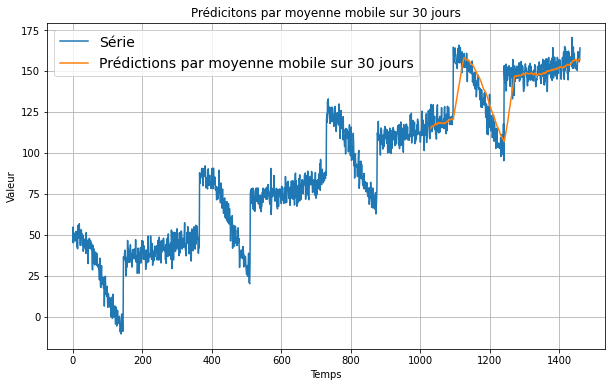

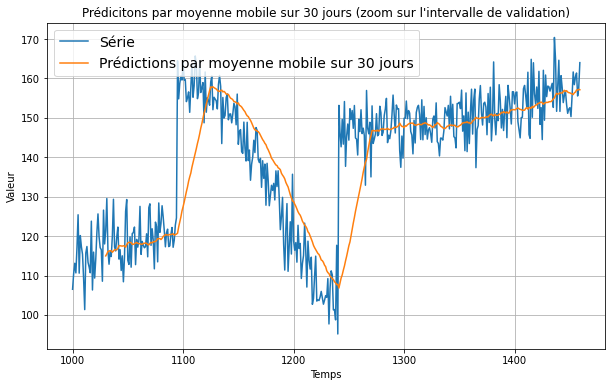

In [54]:
# Applique la moyenne mobile sur la série pendant l'intervalle de validation
moyenne_mobile = prediction_moyenne_mobile(serie, 30)[temps_separation:]

# Affiche les résultats
# Les données de la moyenne mobile commencent à t+30
# donc on ne prend le temps de validation que si t>30 : temps_validation[30:]
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie,label="Série")
affiche_serie(temps_validation[30:], moyenne_mobile,label="Prédictions par moyenne mobile sur 30 jours")
plt.title("Prédicitons par moyenne mobile sur 30 jours")

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, x_validation,label="Série")
affiche_serie(temps_validation[30:], moyenne_mobile,label="Prédictions par moyenne mobile sur 30 jours")
plt.title("Prédicitons par moyenne mobile sur 30 jours (zoom sur l'intervalle de validation)")


# Calcul des erreurs sur la prédiction de la moyenne mobile

On calcule les erreurs à partir du 30ème instant des données de validation car on a utilisé une fenêtre de 30 :

In [55]:
print(keras.metrics.mean_squared_error(x_validation[30:], moyenne_mobile).numpy())
print(keras.metrics.mean_absolute_error(x_validation[30:], moyenne_mobile).numpy())

116.75887764692251
7.376390416252902


Pour être cohérent avec les valeurs trouvées lors de la prédiction naïve, il faut donc calculer les erreurs sur les prédictions naïves à partir du 30ème instant également :

In [56]:
print(keras.metrics.mean_squared_error(x_validation[30:], prediciton_naives[30:-1]).numpy())
print(keras.metrics.mean_absolute_error(x_validation[30:], prediciton_naives[30:-1]).numpy())

60.436445472610274
5.6740773200910715


On a donc une meilleur prédiction avec la méthode naïve. Si on affiche l'ensemble des prédictions réalisées avec les deux techniques on comprend bien pourquoi : La courbe de la moyenne mobile est très éloignée de la courbe originale par endroit.

Text(0.5, 1.0, "Comparaison des prédictions (zoom sur l'intervalle de validation)")

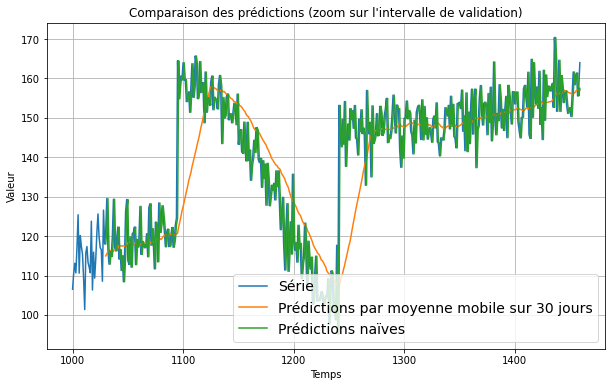

In [59]:
# Affiche les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, x_validation,label="Série")
affiche_serie(temps_validation[30:], moyenne_mobile,label="Prédictions par moyenne mobile sur 30 jours")
affiche_serie(temps_validation[30:], prediciton_naives[30:-1],label="Prédictions naïves")
plt.title("Comparaison des prédictions (zoom sur l'intervalle de validation)")

# Prédictions par moyenne mobile différenciée

L'erreur est plus grande car la moyenne mobile n'anticipe pas la tendance et la saisonnalité de la série. Essayons de les enlever en appliquant la méthode de la différenciation. Comme la période de la saisonnalité est de 365 jours, on choisit de soustraire les valeurs aux instants (t–365) aux valeurs à l'instant t.  
On applique donc la formule : $v_d(t) = v(t) - v(t-365)$, pour $t\in[365,1460[$  
Le résultat obtenu est donc définit sur $t\in[365:1460[$

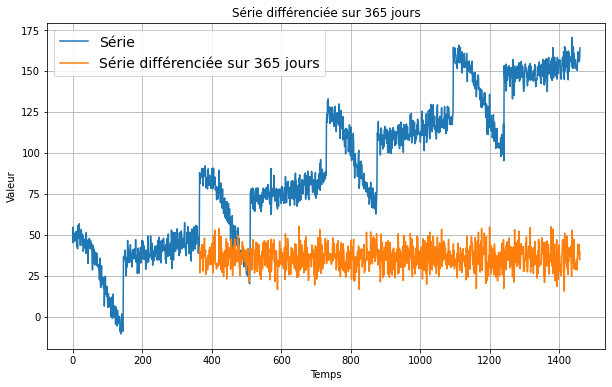

In [61]:
# Serie(t) = Serie(t) - Serie(t-365) pour t: [365;1459]
# Le résultat obtenu est définit sur t=[365:1459]
delta = 365
serie_differenciee = (serie[delta:] - serie[0:-delta])

plt.figure(figsize=(10, 6))
affiche_serie(temps, serie,label="Série")
affiche_serie(temps[delta:], serie_differenciee,label="Série différenciée sur 365 jours")
plt.title("Série différenciée sur 365 jours")
plt.show()

On observe que la saisonnalité et la tendance ont été supprimées. Calculons maintenant la moyenne mobile sur ces données avec une fenêtre de 50 :

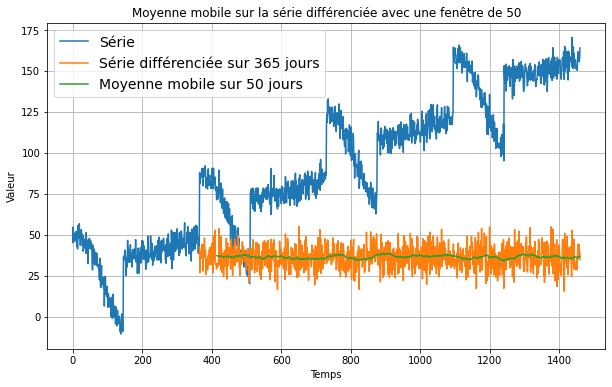

In [63]:
# Moyenne mobile de la série différenciée sur l'intervalle de validation
# Les données de la série différenciée commencent à t=365 donc il faut décaler le tableau de 365
moyenne_mobile_diff = prediction_moyenne_mobile(serie_differenciee, 50)

# Affiche les résultats
# Les données de la moyenne mobile commencent à t+50
# donc on ne prend le temps de validation que si t>50 : temps_validation[50:]
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie,label="Série")
affiche_serie(temps[365:], serie_differenciee,label="Série différenciée sur 365 jours")
affiche_serie(temps[365+50:], moyenne_mobile_diff,label="Moyenne mobile sur 50 jours")
plt.title("Moyenne mobile sur la série différenciée avec une fenêtre de 50")
plt.show()

Ajoutons maintenant les valeurs passées de la série (365 jours avant le début des instants de la moyenne différenciée) avec la moyenne différenciée précédente afin de retrouver la tendance et la saisonnalité :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration_diff2.png?raw=true" width="1024"> 

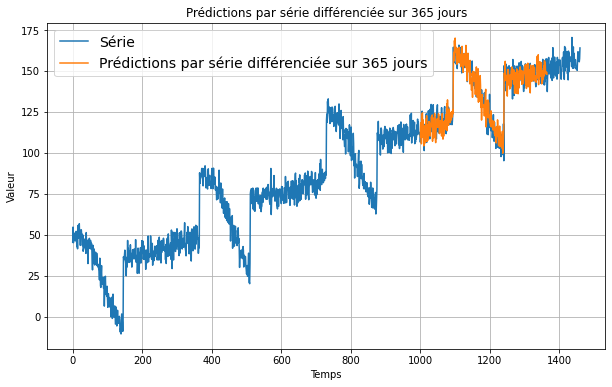

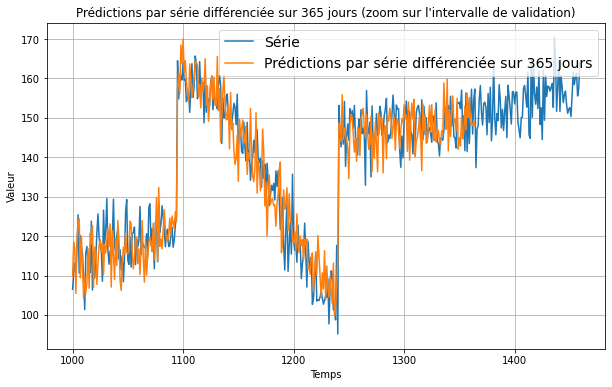

In [84]:
# Reconstruction de la série à partir de la moyenne mobile différenciée
# et des valeurs de la série sur l'intervalle de différenciation
moyenne_mobile_diff_avec_passe = serie[temps_separation-365:temps_separation] + moyenne_mobile_diff[-365:]

# Affichage des résultats
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie,label="Série")
affiche_serie(temps_validation[:365], moyenne_mobile_diff_avec_passe,label="Prédictions par série différenciée sur 365 jours")
plt.title("Prédictions par série différenciée sur 365 jours")
plt.show()

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, serie[temps_separation:],label="Série")
affiche_serie(temps_validation[:365], moyenne_mobile_diff_avec_passe,label="Prédictions par série différenciée sur 365 jours")
plt.title("Prédictions par série différenciée sur 365 jours (zoom sur l'intervalle de validation)")
plt.show()

On voit qu'on ne peut pas aller plus loin dans les prédictions que 365 jours après le temps de validation car nous n'avons pas les données réelles après ce temps là !  
Pour résoudre ce problème, on peut utiliser les données prédites comme source de données à partir de l'instant de validation :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration_diff3.png?raw=true" width="1024"> 

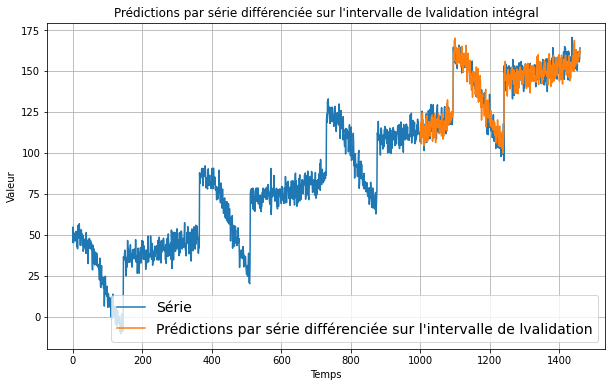

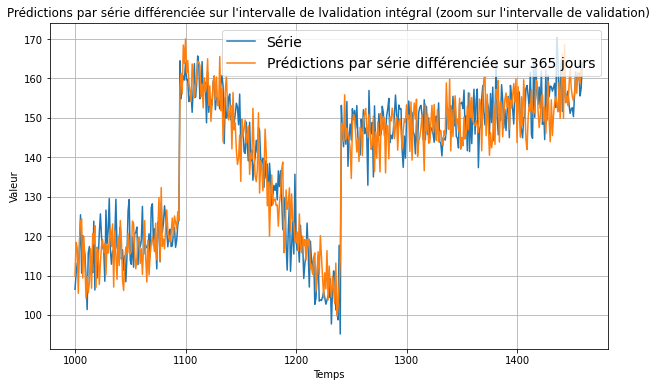

In [91]:
# Reconstruction de la série à partir de la moyenne mobile différenciée
# et des valeurs de la série sur l'intervalle de différenciation
# sur l'intégralité de l'intervalle de validation
longueur_intervalle_validation = len(temps_validation)

# Calcul des prédictions sur les premiers 365 jours de l'intervalle de validation
# en utilisant les données d'entrainement
moyenne_mobile_diff_avec_passe1 = serie[temps_separation-365:temps_separation] + moyenne_mobile_diff[-365:]

# Ajoute les prédictions restantes en s'aidant des données prédites précédentes
moyenne_mobile_diff_avec_passe2 = moyenne_mobile_diff_avec_passe[:longueur_intervalle_validation-365] + moyenne_mobile_diff[-(longueur_intervalle_validation-365):]

# Concatene les deux prédictions
moyenne_mobile_diff_avec_passe = np.concatenate((moyenne_mobile_diff_avec_passe1,moyenne_mobile_diff_avec_passe2))

# Affichage des résultats
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie,label="Série")
affiche_serie(temps_validation, moyenne_mobile_diff_avec_passe,label="Prédictions par série différenciée sur l'intervalle de lvalidation")
plt.title("Prédictions par série différenciée sur l'intervalle de lvalidation intégral")
plt.show()

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, serie[temps_separation:],label="Série")
affiche_serie(temps_validation, moyenne_mobile_diff_avec_passe,label="Prédictions par série différenciée sur 365 jours")
plt.title("Prédictions par série différenciée sur l'intervalle de lvalidation intégral (zoom sur l'intervalle de validation)")
plt.show()

# Calcul des erreurs sur la prédiction de la moyenne mobile différenciée

In [93]:
print(keras.metrics.mean_squared_error(x_validation, moyenne_mobile_diff_avec_passe).numpy())
print(keras.metrics.mean_absolute_error(x_validation, moyenne_mobile_diff_avec_passe).numpy())

52.599065561738605
5.885914900689717


On obtient enfin des erreurs inférieures où très proches de celles obtenues avec les méthode naïve.

# Suppression du bruit sur les données passées

Même si les résultats obtenus sont meilleurs qu'avec la première méthode, les prédictions sont encore bruitées parce que nous avons ajouté les données passées qui sont bruitées.  
Appliquons une moyenne mobile sur les données passées avec une fenêtre de 10 pour supprimer davantage de bruit :

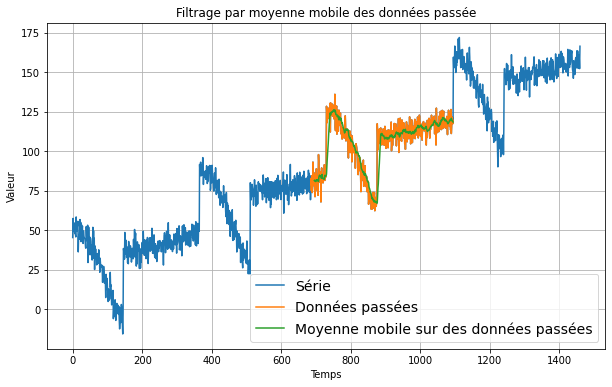

In [ ]:
# Reconstruction de la série à partir de la moyenne mobile différenciée
# et des valeurs de la série à t - 365jours avant les instants de la moyenne
# mobile différenciée (donc à partir de t=temps_separation-365+50)
donnees_passe_non_filtrees = serie[temps_separation+50-365:-365]

# Calcul de la moyenne mobile sur les données passées (t-365)
donnees_passe_filtrees = prediction_moyenne_mobile(donnees_passe_non_filtrees,10)

plt.figure(figsize=(10, 6))
affiche_serie(temps, serie,label="Série")
affiche_serie(temps[temps_separation+50-365:-365], donnees_passe_non_filtrees,label="Données passées")
affiche_serie(temps[temps_separation+50-365+10:-365], donnees_passe_filtrees,label = "Moyenne mobile sur des données passées")
plt.title("Filtrage par moyenne mobile des données passée")
plt.show()

On va maintenant ajouter la moyenne mobile différenciée précédente sur l'intervalle de test aux données passées filtrées par moyenne mobile :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration3.png?raw=true" width="1024"> 

In [ ]:
predictions = donnees_passe_filtrees + moyenne_mobile_diff

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série")
affiche_serie(temps_validation[50:],predictions,label="Prédictions")
plt.title("Prédictions par moyenne mobile différenciée avec les données passées filtrées")
plt.show()

plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation+50:],serie[temps_separation+50:],label="Série")
affiche_serie(temps_validation[60:],predictions,label="Prédictions")
plt.title("Prédictions par moyenne mobile différenciée avec les données passées filtrées (zoom sur l'intervalle de validation)")
plt.show()


ValueError: ignored

# Calcul des erreurs sur la prédiction finale

In [ ]:
print(keras.metrics.mean_squared_error(x_validation, moyenne_mobile_diff_avec_passe_sans_bruit).numpy())
print(keras.metrics.mean_absolute_error(x_validation, moyenne_mobile_diff_avec_passe_sans_bruit).numpy())

36.27104106283883
4.378177665720013
